## GAT on Cora — Enc / Gt / Dec / L

- **Encoder (Enc):** Two Graph Attention Network (GAT) layers transform node features into hidden embeddings using learned attention coefficients to weight neighbor information.
- **Graph transformation (Gt):** Adjacency matrix is used with attention mechanism; attention coefficients are learned to dynamically weight neighbor contributions during message passing.
- **Decoder (Dec):** Final GAT layer projects embeddings to class logits, followed by softmax for per-node class probabilities.
- **Loss (L):** Masked categorical cross-entropy computed only on labeled nodes via sample weights (train/val/test masks).


## 1. Load and preprocess data 


In [ ]:
import os
import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from spektral.layers import GATConv
from spektral.utils import convolution
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from pathlib import Path

# Locate repository root (handles running from notebooks/)
cwd = Path.cwd().resolve()
repo_root = cwd if (cwd / "data").exists() else cwd.parent
DATA_DIR = repo_root / "data"

# Load arrays
X = np.load(DATA_DIR / "X.npy").astype(np.float32)
y = np.load(DATA_DIR / "y.npy").astype(np.float32)
A = sp.load_npz(DATA_DIR / "A.npz")
train_mask = np.load(DATA_DIR / "train_mask.npy")
val_mask = np.load(DATA_DIR / "val_mask.npy")
test_mask = np.load(DATA_DIR / "test_mask.npy")

# Convert to tensors
X = tf.constant(X, dtype=tf.float32)
y = tf.constant(y, dtype=tf.float32)

# Preprocess adjacency: add self-loops + symmetric normalization
A_processed = convolution.gcn_filter(A).tocoo()
A_tensor = tf.sparse.SparseTensor(
    np.array([A_processed.row, A_processed.col]).T,
    A_processed.data.astype(np.float32),
    A_processed.shape,
)
A_tensor = tf.sparse.reorder(A_tensor)

# Masks as float tensors for sample weights
train_mask = tf.constant(train_mask.astype(np.float32))
val_mask = tf.constant(val_mask.astype(np.float32))
test_mask = tf.constant(test_mask.astype(np.float32))

print("✅ Loaded data from disk successfully\n")
print(f"X shape:        {X.shape}")
print(f"y shape:        {y.shape}")
print(f"A shape:        {A.shape} (sparse)")
print(f"Train samples:  {tf.reduce_sum(train_mask).numpy()}")
print(f"Val samples:    {tf.reduce_sum(val_mask).numpy()}")
print(f"Test samples:   {tf.reduce_sum(test_mask).numpy()}")


2025-12-16 20:21:16.444403: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-16 20:21:16.556457: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-12-16 20:21:18.926267: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


✅ Loaded data from disk successfully

X shape:        (2708, 1433)
y shape:        (2708, 7)
A shape:        (2708, 2708) (sparse)
Train samples:  140.0
Val samples:    500.0
Test samples:   1000.0


2025-12-16 20:21:21.665367: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## 2. Inspect splits and shapes

In [2]:
num_nodes, num_features = X.shape
num_classes = y.shape[1]

print("Data splits:")
print(f"  Train: {tf.reduce_sum(train_mask).numpy()} nodes")
print(f"  Val:   {tf.reduce_sum(val_mask).numpy()} nodes")
print(f"  Test:  {tf.reduce_sum(test_mask).numpy()} nodes")
print(f"  Num features: {num_features}")
print(f"  Num classes:  {num_classes}")


Data splits:
  Train: 140.0 nodes
  Val:   500.0 nodes
  Test:  1000.0 nodes
  Num features: 1433
  Num classes:  7


## 3. Build the GAT model

Two GAT layers with attention heads, dropout, and L2 on the first layer; Using 1 attention head for simplicity.


In [ ]:
dropout_rate = 0.5
l2_reg = 5e-4
learning_rate = 0.01
attn_heads = 1  

class NoMaskGAT(GATConv):
    def call(self, inputs, mask=None):
        return super().call(inputs, mask=None)

X_in = layers.Input(shape=(num_features,), name="X_in")
A_in = layers.Input((None,), sparse=True, name="A_in")

x = layers.Dropout(dropout_rate)(X_in)
x = NoMaskGAT(16, attn_heads=attn_heads, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg), dropout_rate=dropout_rate, add_self_loops=False)([x, A_in])
x = layers.Dropout(dropout_rate)(x)
outputs = NoMaskGAT(num_classes, attn_heads=attn_heads, activation="softmax", dropout_rate=dropout_rate, add_self_loops=False)([x, A_in])

model = keras.Model(inputs=[X_in, A_in], outputs=outputs)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ X_in (InputLayer)   │ (None, 1433)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1433)      │          0 │ X_in[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ A_in (InputLayer)   │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ no_mask_gat         │ (None, 16)        │     22,976 │ dropout[0][0],    │
│ (NoMaskGAT)         │                   │            │ A_in[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16)        │          0 │ no_mask_gat[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ no_mask_gat_1       │ (None, 7)         │        133 │ dropout_2[0][0],  │
│ (NoMaskGAT)         │                   │            │ A_in[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,109 (90.27 KB)

 Trainable params: 23,109 (90.27 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Train with masked loss 

Epoch 001 | loss 1.9485 | val_loss 1.9297 | train_acc 0.1429 | val_acc 0.5000


Epoch 002 | loss 1.9197 | val_loss 1.9001 | train_acc 0.4000 | val_acc 0.6300


Epoch 003 | loss 1.8891 | val_loss 1.8616 | train_acc 0.5071 | val_acc 0.6840


Epoch 004 | loss 1.8363 | val_loss 1.8239 | train_acc 0.5286 | val_acc 0.6960


Epoch 005 | loss 1.7839 | val_loss 1.7882 | train_acc 0.5500 | val_acc 0.7420


Epoch 006 | loss 1.7179 | val_loss 1.7493 | train_acc 0.6214 | val_acc 0.7640


Epoch 007 | loss 1.7022 | val_loss 1.7077 | train_acc 0.5500 | val_acc 0.7660


Epoch 008 | loss 1.5707 | val_loss 1.6646 | train_acc 0.6929 | val_acc 0.7560


Epoch 009 | loss 1.5653 | val_loss 1.6211 | train_acc 0.6214 | val_acc 0.7320


Epoch 010 | loss 1.4938 | val_loss 1.5789 | train_acc 0.5929 | val_acc 0.7280


Epoch 011 | loss 1.4106 | val_loss 1.5341 | train_acc 0.6214 | val_acc 0.7220


Epoch 012 | loss 1.3647 | val_loss 1.4848 | train_acc 0.5929 | val_acc 0.7340


Epoch 013 | loss 1.3943 | val_loss 1.4373 | train_acc 0.5500 | val_acc 0.7480


Epoch 014 | loss 1.2739 | val_loss 1.3894 | train_acc 0.5857 | val_acc 0.7520


Epoch 015 | loss 1.2229 | val_loss 1.3465 | train_acc 0.6786 | val_acc 0.7580


Epoch 016 | loss 1.1970 | val_loss 1.3130 | train_acc 0.6571 | val_acc 0.7580


Epoch 017 | loss 1.2343 | val_loss 1.2810 | train_acc 0.6143 | val_acc 0.7680


Epoch 018 | loss 1.1878 | val_loss 1.2562 | train_acc 0.6643 | val_acc 0.7520


Epoch 019 | loss 1.3362 | val_loss 1.2380 | train_acc 0.5857 | val_acc 0.7300


Epoch 020 | loss 1.1631 | val_loss 1.2202 | train_acc 0.6571 | val_acc 0.7280


Epoch 021 | loss 1.0484 | val_loss 1.2078 | train_acc 0.7143 | val_acc 0.7140


Epoch 022 | loss 1.0720 | val_loss 1.1916 | train_acc 0.6571 | val_acc 0.7260


Epoch 023 | loss 1.0524 | val_loss 1.1752 | train_acc 0.6786 | val_acc 0.7280


Epoch 024 | loss 1.0528 | val_loss 1.1589 | train_acc 0.6929 | val_acc 0.7300


Epoch 025 | loss 1.0037 | val_loss 1.1403 | train_acc 0.7071 | val_acc 0.7420


Epoch 026 | loss 1.0408 | val_loss 1.1206 | train_acc 0.7000 | val_acc 0.7600


Epoch 027 | loss 1.0572 | val_loss 1.1019 | train_acc 0.7500 | val_acc 0.7620


Epoch 028 | loss 1.0476 | val_loss 1.0874 | train_acc 0.6929 | val_acc 0.7640


Epoch 029 | loss 1.0301 | val_loss 1.0754 | train_acc 0.6857 | val_acc 0.7660


Epoch 030 | loss 1.0555 | val_loss 1.0625 | train_acc 0.6643 | val_acc 0.7760


Epoch 031 | loss 1.0537 | val_loss 1.0479 | train_acc 0.6929 | val_acc 0.7720


Epoch 032 | loss 0.9192 | val_loss 1.0317 | train_acc 0.7429 | val_acc 0.7660


Epoch 033 | loss 0.8046 | val_loss 1.0152 | train_acc 0.7571 | val_acc 0.7680


Epoch 034 | loss 0.8947 | val_loss 0.9996 | train_acc 0.7786 | val_acc 0.7720


Epoch 035 | loss 0.8810 | val_loss 0.9857 | train_acc 0.7286 | val_acc 0.7740


Epoch 036 | loss 0.7860 | val_loss 0.9741 | train_acc 0.8071 | val_acc 0.7780


Epoch 037 | loss 0.9022 | val_loss 0.9618 | train_acc 0.7500 | val_acc 0.7800


Epoch 038 | loss 0.8436 | val_loss 0.9516 | train_acc 0.7429 | val_acc 0.7800


Epoch 039 | loss 0.8203 | val_loss 0.9419 | train_acc 0.7857 | val_acc 0.7820


Epoch 040 | loss 0.9113 | val_loss 0.9315 | train_acc 0.7429 | val_acc 0.7740


Epoch 041 | loss 0.8716 | val_loss 0.9191 | train_acc 0.7357 | val_acc 0.7780


Epoch 042 | loss 0.7745 | val_loss 0.9066 | train_acc 0.7429 | val_acc 0.7760


Epoch 043 | loss 0.7727 | val_loss 0.8945 | train_acc 0.7786 | val_acc 0.7760


Epoch 044 | loss 0.7257 | val_loss 0.8831 | train_acc 0.7929 | val_acc 0.7760


Epoch 045 | loss 0.7428 | val_loss 0.8731 | train_acc 0.8071 | val_acc 0.7800


Epoch 046 | loss 0.7463 | val_loss 0.8636 | train_acc 0.8143 | val_acc 0.7760


Epoch 047 | loss 0.7987 | val_loss 0.8531 | train_acc 0.8143 | val_acc 0.7800


Epoch 048 | loss 0.7847 | val_loss 0.8416 | train_acc 0.7857 | val_acc 0.7800


Epoch 049 | loss 0.8011 | val_loss 0.8297 | train_acc 0.7429 | val_acc 0.7780


Epoch 050 | loss 0.7040 | val_loss 0.8182 | train_acc 0.7786 | val_acc 0.7760


Epoch 051 | loss 0.6765 | val_loss 0.8065 | train_acc 0.8000 | val_acc 0.7740


Epoch 052 | loss 0.7322 | val_loss 0.7953 | train_acc 0.7643 | val_acc 0.7740


Epoch 053 | loss 0.6608 | val_loss 0.7879 | train_acc 0.8071 | val_acc 0.7760


Epoch 054 | loss 0.7775 | val_loss 0.7812 | train_acc 0.7214 | val_acc 0.7760


Epoch 055 | loss 0.7108 | val_loss 0.7731 | train_acc 0.8214 | val_acc 0.7800


Epoch 056 | loss 0.7297 | val_loss 0.7664 | train_acc 0.7571 | val_acc 0.7780


Epoch 057 | loss 0.8145 | val_loss 0.7610 | train_acc 0.7214 | val_acc 0.7780


Epoch 058 | loss 0.7100 | val_loss 0.7575 | train_acc 0.7857 | val_acc 0.7780


Epoch 059 | loss 0.6362 | val_loss 0.7543 | train_acc 0.8071 | val_acc 0.7780


Epoch 060 | loss 0.6460 | val_loss 0.7540 | train_acc 0.8214 | val_acc 0.7800


Epoch 061 | loss 0.6180 | val_loss 0.7537 | train_acc 0.8214 | val_acc 0.7800


Epoch 062 | loss 0.5934 | val_loss 0.7539 | train_acc 0.8143 | val_acc 0.7820


Epoch 063 | loss 0.6677 | val_loss 0.7544 | train_acc 0.7714 | val_acc 0.7800


Epoch 064 | loss 0.6258 | val_loss 0.7535 | train_acc 0.8143 | val_acc 0.7820


Epoch 065 | loss 0.6449 | val_loss 0.7535 | train_acc 0.7929 | val_acc 0.7740


Epoch 066 | loss 0.6340 | val_loss 0.7525 | train_acc 0.7929 | val_acc 0.7680


Epoch 067 | loss 0.6143 | val_loss 0.7513 | train_acc 0.8214 | val_acc 0.7680


Epoch 068 | loss 0.5583 | val_loss 0.7479 | train_acc 0.8286 | val_acc 0.7720


Epoch 069 | loss 0.6262 | val_loss 0.7442 | train_acc 0.7643 | val_acc 0.7640


Epoch 070 | loss 0.6752 | val_loss 0.7390 | train_acc 0.7643 | val_acc 0.7680


Epoch 071 | loss 0.6781 | val_loss 0.7338 | train_acc 0.7357 | val_acc 0.7720


Epoch 072 | loss 0.6550 | val_loss 0.7297 | train_acc 0.7571 | val_acc 0.7720


Epoch 073 | loss 0.6207 | val_loss 0.7244 | train_acc 0.8286 | val_acc 0.7780


Epoch 074 | loss 0.5993 | val_loss 0.7198 | train_acc 0.8000 | val_acc 0.7760


Epoch 075 | loss 0.6715 | val_loss 0.7161 | train_acc 0.7786 | val_acc 0.7720


Epoch 076 | loss 0.6924 | val_loss 0.7118 | train_acc 0.7857 | val_acc 0.7720


Epoch 077 | loss 0.5637 | val_loss 0.7060 | train_acc 0.7643 | val_acc 0.7780


Epoch 078 | loss 0.6551 | val_loss 0.6994 | train_acc 0.8143 | val_acc 0.7860


Epoch 079 | loss 0.5895 | val_loss 0.6942 | train_acc 0.7929 | val_acc 0.7840


Epoch 080 | loss 0.5446 | val_loss 0.6904 | train_acc 0.8429 | val_acc 0.7780


Epoch 081 | loss 0.5827 | val_loss 0.6887 | train_acc 0.8000 | val_acc 0.7840


Epoch 082 | loss 0.6429 | val_loss 0.6884 | train_acc 0.7929 | val_acc 0.7820


Epoch 083 | loss 0.6096 | val_loss 0.6872 | train_acc 0.7857 | val_acc 0.7820


Epoch 084 | loss 0.5938 | val_loss 0.6860 | train_acc 0.8000 | val_acc 0.7780


Epoch 085 | loss 0.6626 | val_loss 0.6859 | train_acc 0.7929 | val_acc 0.7800


Epoch 086 | loss 0.6293 | val_loss 0.6871 | train_acc 0.8000 | val_acc 0.7820


Epoch 087 | loss 0.6086 | val_loss 0.6883 | train_acc 0.7929 | val_acc 0.7840


Epoch 088 | loss 0.6530 | val_loss 0.6914 | train_acc 0.7714 | val_acc 0.7860


Epoch 089 | loss 0.5932 | val_loss 0.6955 | train_acc 0.8214 | val_acc 0.7860


Epoch 090 | loss 0.5618 | val_loss 0.6997 | train_acc 0.8286 | val_acc 0.7840


Epoch 091 | loss 0.5629 | val_loss 0.7053 | train_acc 0.8071 | val_acc 0.7820


Epoch 092 | loss 0.5846 | val_loss 0.7110 | train_acc 0.7929 | val_acc 0.7760


Epoch 093 | loss 0.6418 | val_loss 0.7168 | train_acc 0.7571 | val_acc 0.7720


Epoch 094 | loss 0.5822 | val_loss 0.7214 | train_acc 0.8214 | val_acc 0.7720


Epoch 095 | loss 0.6171 | val_loss 0.7236 | train_acc 0.8286 | val_acc 0.7700


Epoch 096 | loss 0.4644 | val_loss 0.7250 | train_acc 0.8286 | val_acc 0.7700
Early stopping


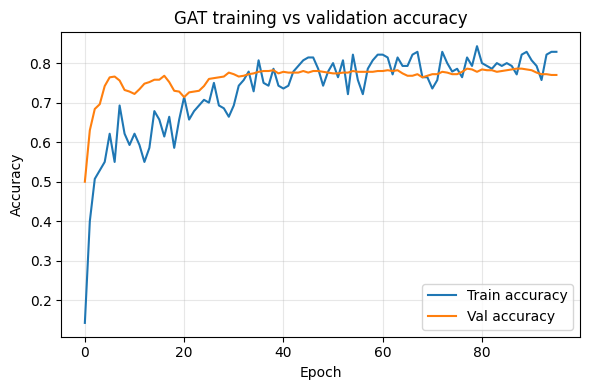

In [4]:
epochs = 100
patience = 10

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = keras.losses.CategoricalCrossentropy(reduction="none")

history_acc = []
history_val_acc = []
best_val_loss = float("inf")
wait = 0
best_weights = None

train_mask_tf = tf.convert_to_tensor(train_mask)
val_mask_tf = tf.convert_to_tensor(val_mask)
mask_train_norm = tf.reduce_sum(train_mask_tf)
mask_val_norm = tf.reduce_sum(val_mask_tf)

for epoch in range(1, epochs + 1):
    with tf.GradientTape() as tape:
        logits = model([X, A_tensor], training=True)
        loss_raw = loss_fn(y, logits)
        loss = tf.reduce_sum(loss_raw * train_mask_tf) / mask_train_norm
        total_loss = loss + tf.add_n(model.losses)
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Train metrics (masked)
    train_pred = tf.argmax(logits, axis=1)
    train_true = tf.argmax(y, axis=1)
    correct_train = tf.cast(tf.equal(train_pred, train_true), tf.float32)
    train_acc = tf.reduce_sum(correct_train * train_mask_tf) / mask_train_norm

    # Validation metrics (masked)
    val_logits = model([X, A_tensor], training=False)
    val_loss_raw = loss_fn(y, val_logits)
    val_loss = tf.reduce_sum(val_loss_raw * val_mask_tf) / mask_val_norm
    val_pred = tf.argmax(val_logits, axis=1)
    val_true = tf.argmax(y, axis=1)
    correct_val = tf.cast(tf.equal(val_pred, val_true), tf.float32)
    val_acc = tf.reduce_sum(correct_val * val_mask_tf) / mask_val_norm

    history_acc.append(float(train_acc))
    history_val_acc.append(float(val_acc))

    print(f"Epoch {epoch:03d} | loss {float(loss):.4f} | val_loss {float(val_loss):.4f} | train_acc {float(train_acc):.4f} | val_acc {float(val_acc):.4f}")

    if val_loss < best_val_loss:
        best_val_loss = float(val_loss)
        wait = 0
        best_weights = model.get_weights()
    else:
        wait += 1
        if wait > patience:
            print("Early stopping")
            break

if best_weights is not None:
    model.set_weights(best_weights)

# Training/validation accuracy plot
plt.figure(figsize=(6, 4))
plt.plot(history_acc, label="Train accuracy")
plt.plot(history_val_acc, label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("GAT training vs validation accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 5. Evaluate on train/val/test 

Compute accuracy, macro precision/recall/F1 on each split. 

In [5]:
logits = model([X, A_tensor], training=False)
labels_true = tf.argmax(y, axis=1).numpy()
labels_pred = tf.argmax(logits, axis=1).numpy()

results = {}
for split_name, mask in {
    "train": train_mask,
    "val": val_mask,
    "test": test_mask,
}.items():
    mask_np = mask.numpy().astype(bool)
    true_split = labels_true[mask_np]
    pred_split = labels_pred[mask_np]
    acc = accuracy_score(true_split, pred_split)
    prec, rec, f1, _ = precision_recall_fscore_support(
        true_split, pred_split, average="macro", zero_division=0
    )
    results[split_name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }
    print(f"{split_name.title()} metrics:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1:        {f1:.4f}\n")

if results["test"]["accuracy"] < 0.566:
    raise ValueError("Test accuracy fell below MLP baseline (0.566); please debug before proceeding.")


Train metrics:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1:        1.0000

Val metrics:
  Accuracy:  0.7800
  Precision: 0.7621
  Recall:    0.7871
  F1:        0.7723

Test metrics:
  Accuracy:  0.8170
  Precision: 0.7960
  Recall:    0.8222
  F1:        0.8074



## 6. Save test metrics 



In [6]:
import csv

RESULTS_DIR = repo_root / "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

metrics_path = RESULTS_DIR / "metrics.csv"
file_exists = metrics_path.exists()

fieldnames = [
    "model",
    "dataset",
    "test_accuracy",
    "test_precision_macro",
    "test_recall_macro",
    "test_f1_macro",
]

test_res = results["test"]
row = {
    "model": "gat",
    "dataset": "cora",
    "test_accuracy": f"{test_res['accuracy']:.4f}",
    "test_precision_macro": f"{test_res['precision']:.4f}",
    "test_recall_macro": f"{test_res['recall']:.4f}",
    "test_f1_macro": f"{test_res['f1']:.4f}",
}

with open(metrics_path, mode="a", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    if not file_exists:
        writer.writeheader()
    writer.writerow(row)

print(f"✅ Saved GAT metrics to {metrics_path}")


✅ Saved GAT metrics to /home/rebu/Desktop/Projects/Interns/Icog labs/training-tasks/GNN-Models/results/metrics.csv
